In [89]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = 12,8

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy.ma as ma
from scipy.optimize import curve_fit

In [53]:
def get_data(file_name):
    data = np.genfromtxt(file_name, dtype=float, delimiter=None,
                         skip_header=2, names=["Qx", "Qy", "I(Qx,Qy)", "err(I)"])
    shape_x = len(np.unique(data['Qx']))
    shape_y = len(np.unique(data['Qy']))
    data_x = data['Qx']  # .reshape(shape_x, shape_y)
    data_y = data['Qy']  # .reshape(shape_x, shape_y)
    data_z = data['IQxQy']  # .reshape(shape_x, shape_y)
    return data_x, data_y, data_z

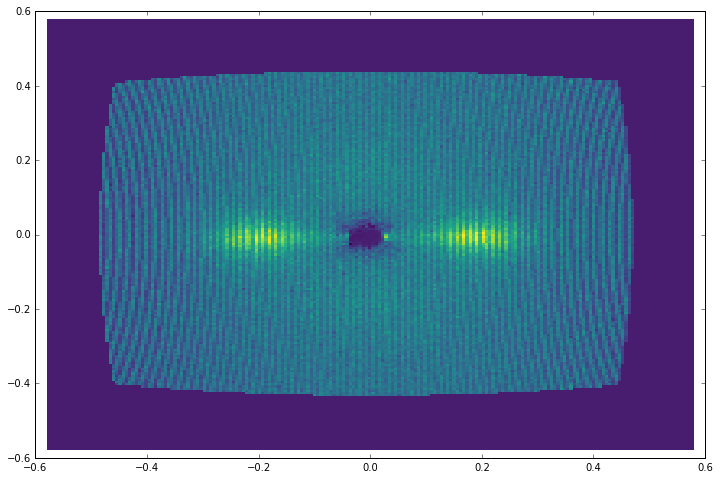

In [59]:
data_x, data_y, data_z = get_data("./Bio-SANS/anisotropy_with-peak/high-q-has_peak/BioSANS_exp317_scan0021_0001_Iqxy.dat")

# Raw image
shape_x = len(np.unique(data_x))
shape_y = len(np.unique(data_y))
X = data_x.reshape(shape_x, shape_y)
Y = data_y.reshape(shape_x, shape_y)
Z = data_z.reshape(shape_x, shape_y)
plt.pcolormesh(X, Y, Z)


In [60]:
def sector_average(data_x, data_y, data_z, 
                   n_bins_angle=100, n_bins_radius=50, max_radius = np.inf):
    
    radius = np.linalg.norm(np.column_stack((data_x, data_y)), axis=1)

    angle = np.arctan2(data_y, data_x)
    angle = np.rad2deg(angle)
    # make it integer from 0 to 360
    angle = np.round(angle).astype(int) + 180

    angle = angle[radius <= max_radius]
    # radius for every pixel

    # normalize data to 1
    data_z = (data_z - data_z.min()) / (data_z.max() - data_z.min())
    data_z = (data_z)**(1/2)
    data_z =data_z[radius <= max_radius]
    radius = radius[radius <= max_radius]

    H, xedges, yedges, binnumber = stats.binned_statistic_2d(angle, radius, data_z,
                                       bins=[n_bins_angle, n_bins_radius],
                                       statistic='mean')

    xedges_width = (xedges[1] - xedges[0])
    xedges_center = xedges[1:] - xedges_width / 2

    yedges_width = (yedges[1] - yedges[0])
    yedges_center = yedges[1:] - yedges_width / 2

    xedges_center = np.linspace(np.amin(xedges_center), np.amax(xedges_center), len(xedges_center))

    return H, xedges_center, yedges_center


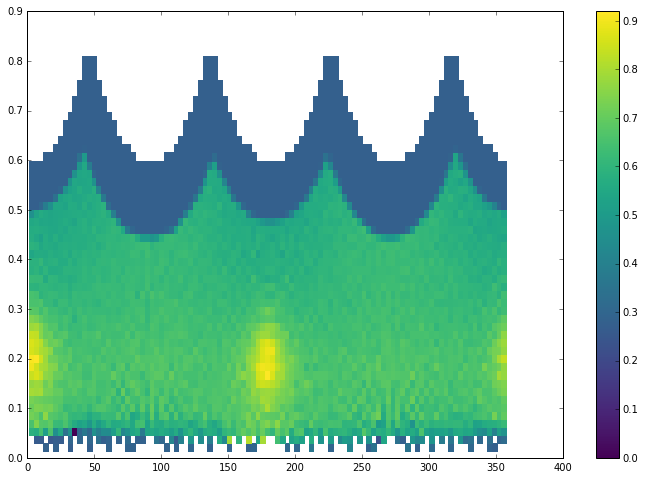

In [61]:
# Sectors
H, x, y = sector_average(data_x, data_y, data_z)
X, Y = np.meshgrid(x, y)
H_masked_nans = ma.masked_where(np.isnan(H),H)
plt.pcolormesh(X, Y, H_masked_nans.T)
plt.colorbar()

In [87]:
def annulus(data_x, data_y, data_z, 
                   n_bins=100, min_radius=0.1, max_radius = 0.3):
    
    radius = np.linalg.norm(np.column_stack((data_x, data_y)), axis=1)

    angle = np.arctan2(data_y, data_x)
    angle = np.rad2deg(angle)
    # make it integer from 0 to 360
    angle = np.round(angle).astype(int) + 180
    
    radius_condition = (radius <= max_radius) & (radius >= min_radius)
    angle = angle[radius_condition]
    
    # normalize data to 1
    data_z = (data_z - data_z.min()) / (data_z.max() - data_z.min())
    data_z = data_z[radius_condition]
    
   

    H, edges, binnumber = stats.binned_statistic(angle, data_z,
                                       bins=n_bins,statistic='mean')

    edges_width = (edges[1] - edges[0])
    edges_center = edges[1:] - edges_width / 2


    edges_center = np.linspace(np.amin(edges_center), np.amax(edges_center), len(edges_center))

    return H, edges_center

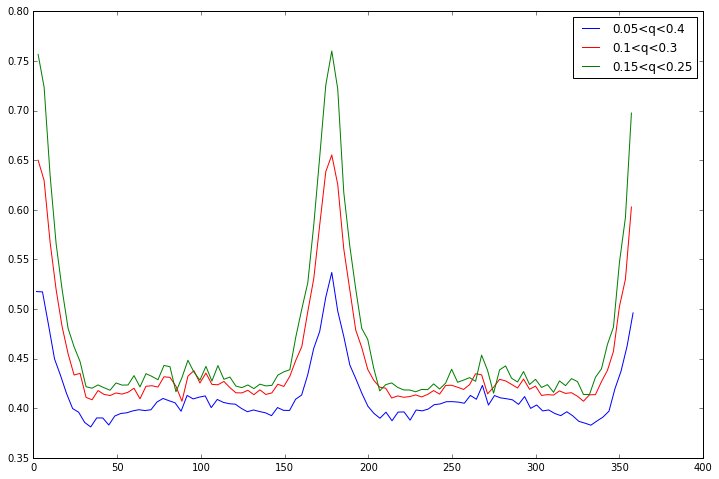

In [88]:
# annulus (bins in between 2 circles)
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.05, max_radius = 0.4)
plt.plot(x,H,c='b',label="0.05<q<0.4")
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.1, max_radius = 0.3)
plt.plot(x,H,c='r',label="0.1<q<0.3")
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.15, max_radius = 0.25)
plt.plot(x,H,c='g',label="0.15<q<0.25")
plt.legend()

[   0.29763587  177.63516868    8.29327175    0.44889979]


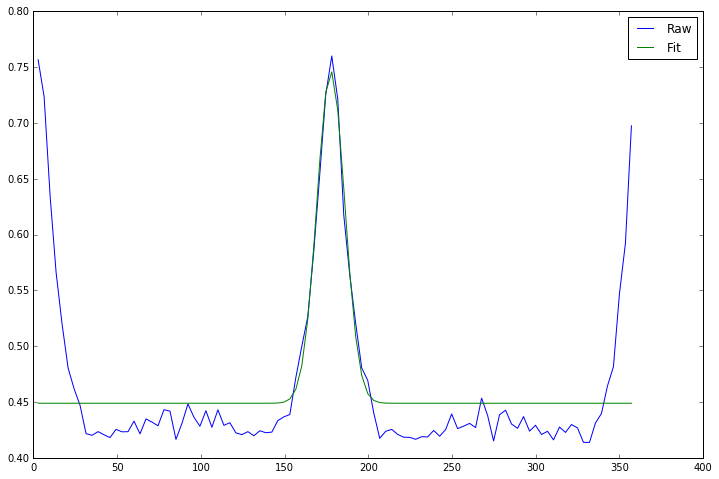

In [110]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma, base = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + base

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [0.4, 180., 5, 0.4]

coeff, var_matrix = curve_fit(gauss, x, H, p0=p0)

# Get the fitted curve
fit = gauss(x, *coeff)


plt.plot(x, H, label='Raw')
plt.plot(x, fit, label='Fit')
plt.legend()
print(coeff)